✅ Global Maximum Sequence Length: 74

Processing Fold 1...
2/2 [==============================] - 0s 6ms/step

Processing Fold 2...
2/2 [==============================] - 0s 5ms/step

Processing Fold 3...
2/2 [==============================] - 0s 9ms/step

Processing Fold 4...
2/2 [==============================] - 0s 6ms/step

Processing Fold 5...
2/2 [==============================] - 0s 9ms/step

Generating Confusion Matrix for Positive_Emotions...


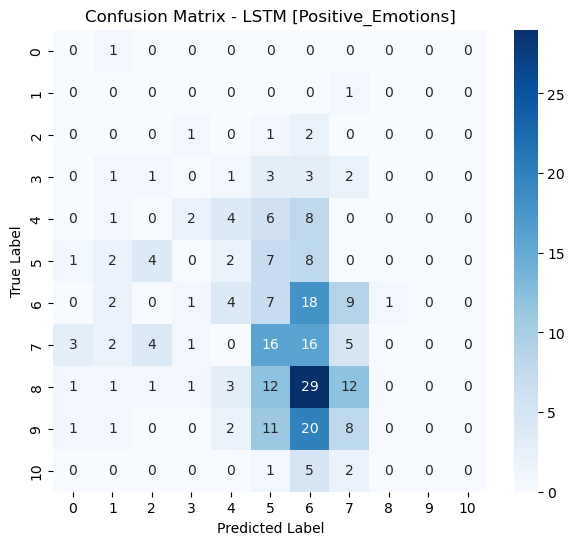

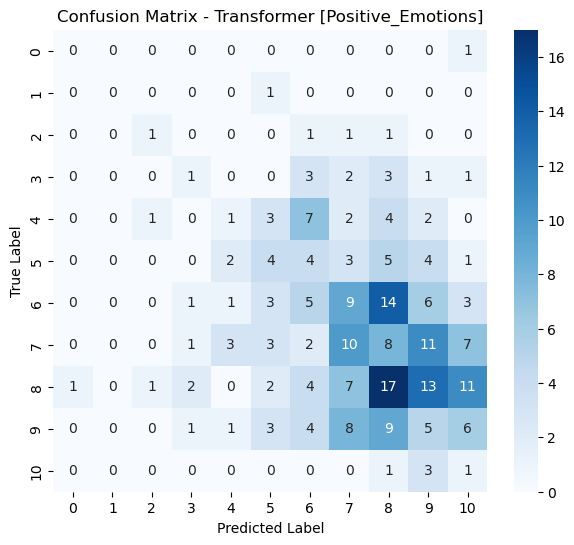


Generating Confusion Matrix for Negative_Emotions...


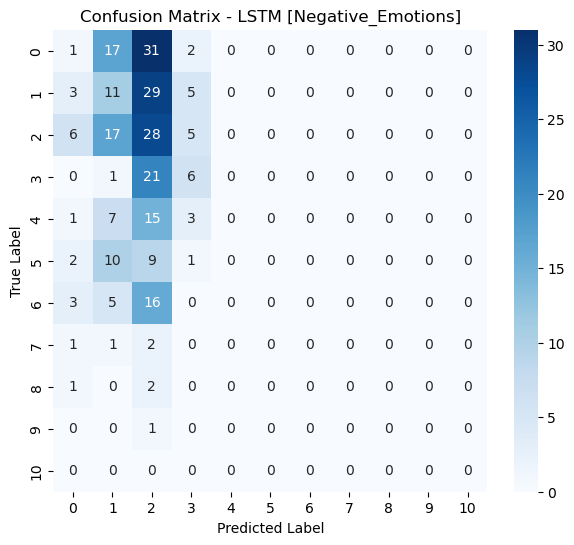

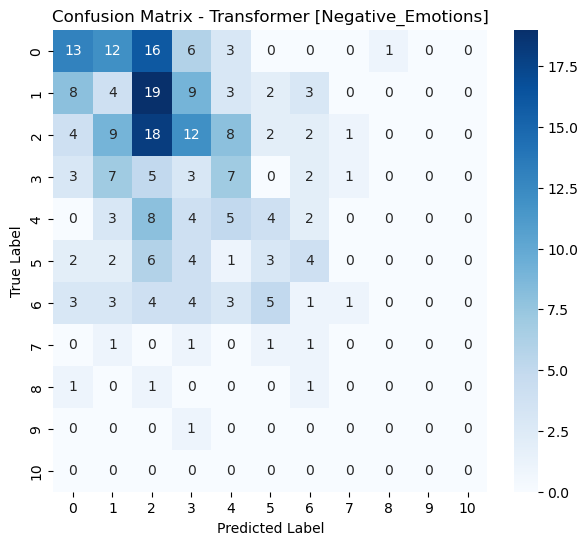


Generating Confusion Matrix for Self_Esteem...


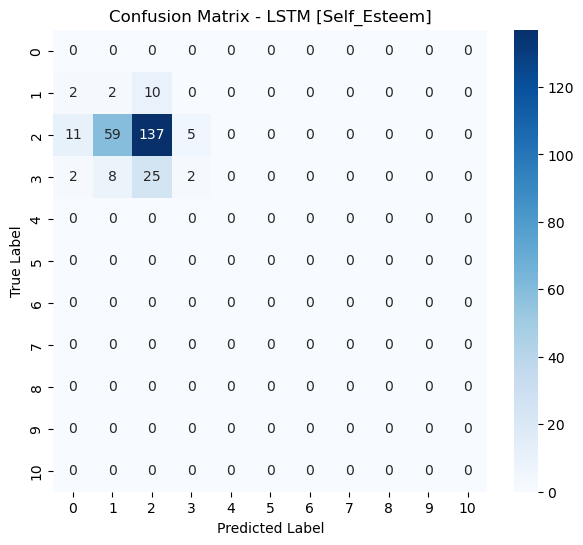

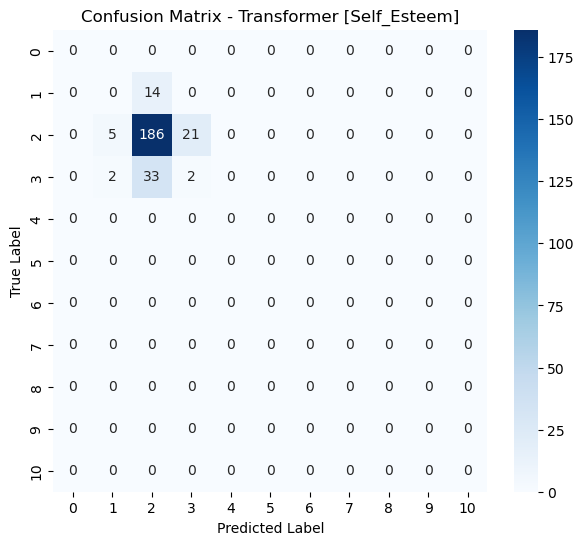


Generating Confusion Matrix for Meaning_in_Life...


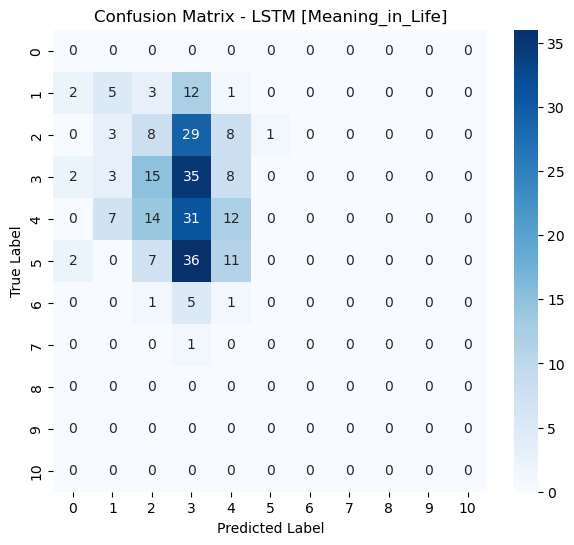

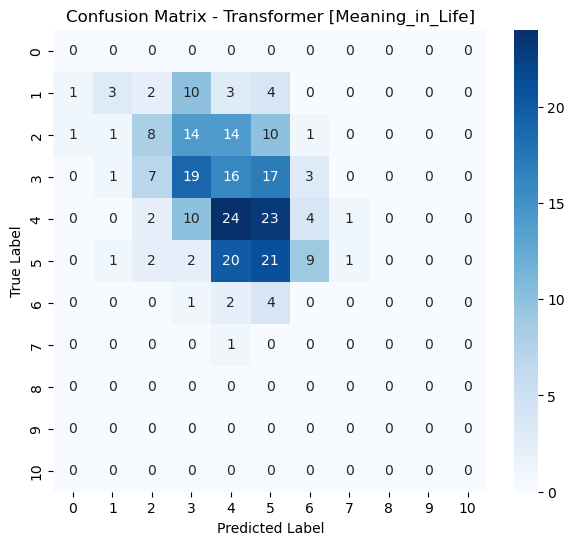


Generating Confusion Matrix for Social_Support...


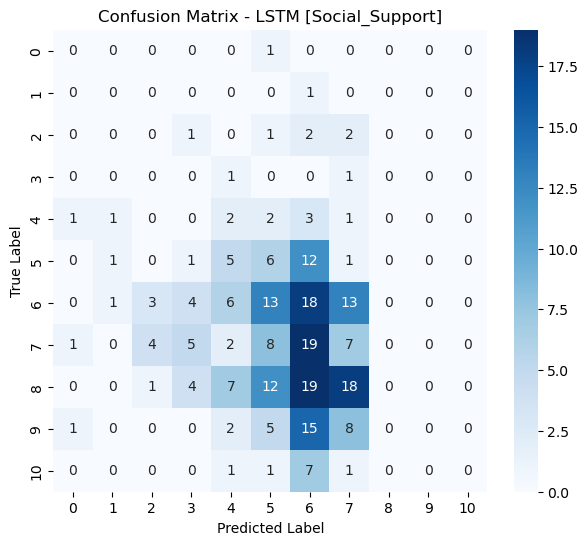

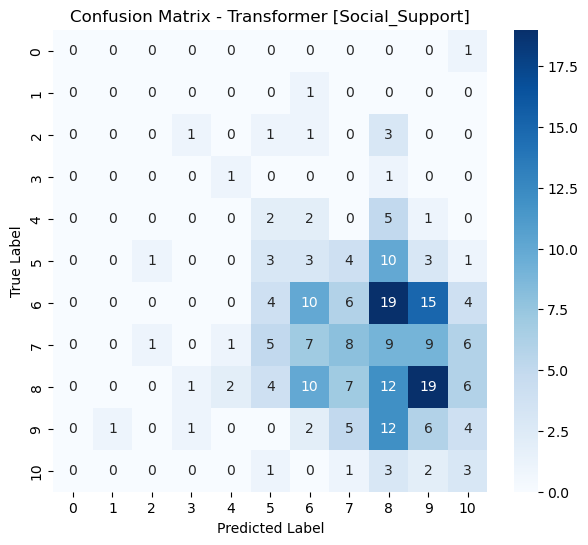


✅ Confusion matrices generated and saved for all labels across all folds!


In [8]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# Number of folds
NUM_FOLDS = 5

# Define paths for LSTM and Transformer models
LSTM_PATH = "2Ddata_LSTM/lstm_model_fold{}.h5"
TRANSFORMER_PATH = "2Ddata_Transformer/transformer_model_fold{}.keras"

# Define label columns
label_columns = ["Positive_Emotions", "Negative_Emotions", "Self_Esteem", "Meaning_in_Life", "Social_Support"]

# Define binning strategy for categorizing continuous values
NUM_CLASSES = 11  # Assuming labels range from 0 to 10
bins = np.linspace(0, 10, NUM_CLASSES + 1)  # Ensure uniform binning

# Step 1: Compute the global maximum sequence length
global_max_seq_length = 0

for fold in range(1, NUM_FOLDS + 1):
    with open(f"train_2d_fold{fold}.pkl", "rb") as f:
        train_dict = pickle.load(f)
    with open(f"test_2d_fold{fold}.pkl", "rb") as f:
        test_dict = pickle.load(f)

    train_lengths = [len(seq) for seq in train_dict["data"]]
    test_lengths = [len(seq) for seq in test_dict["data"]]

    fold_max_length = max(max(train_lengths), max(test_lengths))
    global_max_seq_length = max(global_max_seq_length, fold_max_length)

print(f"✅ Global Maximum Sequence Length: {global_max_seq_length}")

# Function to load and preprocess data (both train and test)
def load_data(fold):
    with open(f"train_2d_fold{fold}.pkl", "rb") as f:
        train_dict = pickle.load(f)
    with open(f"test_2d_fold{fold}.pkl", "rb") as f:
        test_dict = pickle.load(f)

    # Extract column indices
    columns = train_dict["columns"]
    label_indices = [columns.index(col) for col in label_columns]
    feature_indices = [i for i in range(len(columns)) if i not in label_indices and columns[i] != "participant_id"]

    # Extract raw features and labels
    X_train_raw = [np.array(seq[:, feature_indices], dtype=np.float32) for seq in train_dict["data"]]
    y_train_raw = [np.array(seq[:, label_indices], dtype=np.float32) for seq in train_dict["data"]]

    X_test_raw = [np.array(seq[:, feature_indices], dtype=np.float32) for seq in test_dict["data"]]
    y_test_raw = [np.array(seq[:, label_indices], dtype=np.float32) for seq in test_dict["data"]]

    # Fit scaler on training data and apply to test data
    X_train_flattened = np.vstack(X_train_raw)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flattened)

    X_test_flattened = np.vstack(X_test_raw)
    X_test_scaled = scaler.transform(X_test_flattened)

    # Restore sequence structure
    X_train_fixed, X_test_fixed = [], []
    
    start = 0
    for seq in X_train_raw:
        length = len(seq)
        X_train_fixed.append(X_train_scaled[start:start + length])
        start += length

    start = 0
    for seq in X_test_raw:
        length = len(seq)
        X_test_fixed.append(X_test_scaled[start:start + length])
        start += length

    # Pad sequences using the global max length
    X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_fixed, maxlen=global_max_seq_length, dtype="float32", padding="post")

    # Extract the last timestep labels
    y_test_final = np.array([seq[-1] for seq in y_test_raw], dtype=np.float32)

    return X_test_padded, y_test_final

# Function to make predictions using a model
def predict_model(model_path, X_test_padded):
    model = tf.keras.models.load_model(model_path)
    return model.predict(X_test_padded)

# Function to plot confusion matrices for all folds in one figure
def plot_confusion_matrix(all_y_true, all_y_pred, model_name, label_name, label_index):
    # Compute overall confusion matrix
    cm = confusion_matrix(all_y_true, all_y_pred, labels=np.arange(NUM_CLASSES))

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name} [{label_name}]")
    plt.savefig(f"2Ddata_Transformer/confusion_matrix_{model_name}_{label_index}.png")
    plt.show()

# **Store all results to generate a single confusion matrix per label**
all_y_test = {label: [] for label in label_columns}
all_lstm_preds = {label: [] for label in label_columns}
all_transformer_preds = {label: [] for label in label_columns}

# Loop through each fold to gather predictions
for fold in range(1, NUM_FOLDS + 1):
    print(f"\nProcessing Fold {fold}...")

    # Load test data
    X_test_padded, y_test = load_data(fold)

    # Load and predict using LSTM
    lstm_preds = predict_model(LSTM_PATH.format(fold), X_test_padded)

    # Load and predict using Transformer
    transformer_preds = predict_model(TRANSFORMER_PATH.format(fold), X_test_padded)

    # Convert to categorical labels using bins
    for label_index, label_name in enumerate(label_columns):
        y_test_cat = np.clip(y_test[:, label_index], 0, 10)
        lstm_preds_clipped = np.clip(lstm_preds[:, label_index], 0, 10)
        transformer_preds_clipped = np.clip(transformer_preds[:, label_index], 0, 10)

        # Convert to categorical bins
        y_test_cat = np.digitize(y_test_cat, bins) - 1
        lstm_preds_cat = np.digitize(lstm_preds_clipped, bins) - 1
        transformer_preds_cat = np.digitize(transformer_preds_clipped, bins) - 1

        # Store all folds together
        all_y_test[label_name].extend(y_test_cat)
        all_lstm_preds[label_name].extend(lstm_preds_cat)
        all_transformer_preds[label_name].extend(transformer_preds_cat)

# Generate single confusion matrix per label across all folds
for label_index, label_name in enumerate(label_columns):
    print(f"\nGenerating Confusion Matrix for {label_name}...")

    # Convert lists to numpy arrays
    all_y_test[label_name] = np.array(all_y_test[label_name])
    all_lstm_preds[label_name] = np.array(all_lstm_preds[label_name])
    all_transformer_preds[label_name] = np.array(all_transformer_preds[label_name])

    # Plot confusion matrices
    plot_confusion_matrix(all_y_test[label_name], all_lstm_preds[label_name], "LSTM", label_name, label_index)
    plot_confusion_matrix(all_y_test[label_name], all_transformer_preds[label_name], "Transformer", label_name, label_index)

print("\n✅ Confusion matrices generated and saved for all labels across all folds!")
